# 🏔️ Visualize Loss Landscape

In this notebook, a simplified loss [landscape](https://losslandscape.com/) visualization for neural networks is implemented. The notebook will visualize the effect of using a skip connection.

## Quick recap


For a loss function $L(\theta)$  the technique construct $f(\alpha,\beta) = L(\theta+\alpha \delta+\beta \eta)$, where :

$\theta$: is the optimized neural network parameters.

$\delta, \eta$: The random direction in the parameter space.

$\alpha, \beta$: The grid coordinates.

In essence, for a neural network parameters, the method perturb the weights in random direction with different scale on a grid, then evaluate the loss function at each grid point.

## Imports

In [ ]:
!pip install git+https://github.com/ASEM000/serket --quiet
!pip install optax --quiet
!pip install tqdm --quiet
!pip install ml_collections --quiet

In [1]:
import requests
from io import BytesIO
import jax
import jax.numpy as jnp
import jax.random as jr
import jax.tree_util as jtu
import functools as ft
import optax  # for gradient optimization
import serket as sk
import matplotlib.pyplot as plt  # for plotting the predictions
from tqdm import tqdm  # for progress bar
from ml_collections import ConfigDict  # for configuration
from typing import TypeVar, Generic
from typing_extensions import Annotated, Callable

T = TypeVar("T")


class Batched(Generic[T]):
    ...


CHWArray = Annotated[jax.Array, "CHW"]

config = ConfigDict()
config.EPOCHS = 1
config.LR = 1e-3
config.BATCH_SIZE = 128
config.seed = 0
config.optim = optax.adam

## Data preparation

In [2]:
url = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz"
data = jnp.load(BytesIO(requests.get(url).content))

x_train = data["x_train"].reshape(-1, 1, 28, 28).astype("float32") / 255.0
x_train = jnp.array_split(x_train, x_train.shape[0] // config.BATCH_SIZE)
y_train = jnp.array_split(data["y_train"], len(data["y_train"]) // config.BATCH_SIZE)

x_test = data["x_test"].reshape(-1, 1, 28, 28).astype("float32") / 255.0
y_test = data["y_test"]

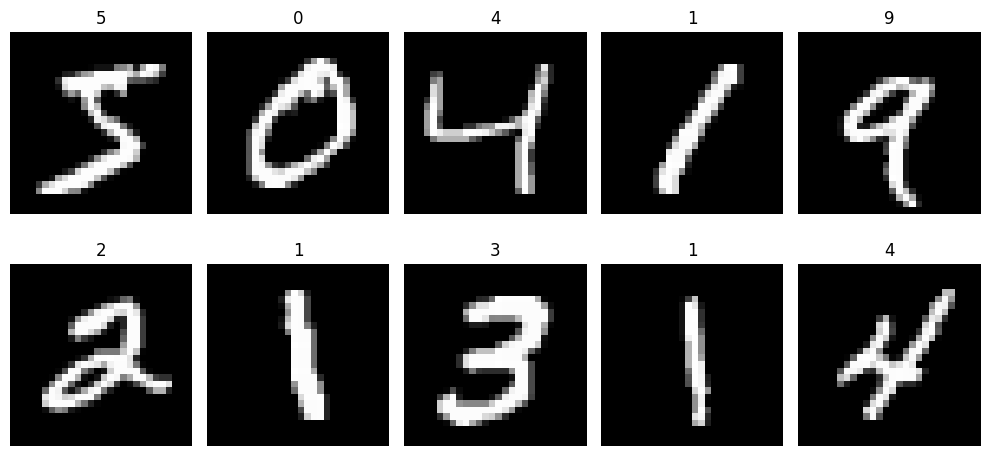

In [3]:
# visualize the data
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(x_train[0][i].squeeze(), cmap="gray")
    ax.set_title(y_train[0][i])
    ax.axis("off")
plt.tight_layout()

## Model preparation

Construct two convnets, one with skip connections and one without it.

In [4]:
class ResBlock(sk.TreeClass):
    def __init__(self, in_features: int, out_features: int, *, key: jax.Array):
        k1, k2 = jr.split(key)
        self.conv1 = sk.nn.Conv2D(in_features, out_features, 3, key=k1)
        self.conv2 = sk.nn.Conv2D(out_features, out_features, 3, key=k2)

    def __call__(self, input: jax.Array) -> jax.Array:
        out = jax.nn.relu(self.conv1(input))
        out = jax.nn.relu(self.conv2(out))
        return jax.nn.relu(out + input)


class SansResBlock(sk.TreeClass):
    def __init__(self, in_features: int, out_features: int, *, key: jax.Array):
        k1, k2 = jr.split(key)
        self.conv1 = sk.nn.Conv2D(in_features, out_features, 3, key=k1)
        self.conv2 = sk.nn.Conv2D(out_features, out_features, 3, key=k2)

    def __call__(self, input: jax.Array) -> jax.Array:
        out = jax.nn.relu(self.conv1(input))
        out = jax.nn.relu(self.conv2(out))
        return out


class ResConvNet(sk.TreeClass):
    def __init__(self, in_features: int, out_features: int, *, key: jax.Array):
        k1, k2, k3, k4 = jr.split(key, 4)
        self.conv1 = ResBlock(in_features, out_features, key=k1)
        self.conv2 = ResBlock(out_features, out_features, key=k2)
        self.conv3 = ResBlock(out_features, out_features, key=k3)
        self.pool = sk.nn.MaxPool2D(2, 2)
        self.final = sk.nn.Conv2D(out_features, 10, 1, key=k4)

    def __call__(self, input: jax.Array) -> jax.Array:
        out = self.conv1(input)
        out = self.pool(out)
        out = self.conv2(out)
        out = self.pool(out)
        out = self.conv3(out)
        out = self.pool(out)
        out = self.final(out)
        out = jnp.mean(out, axis=(1, 2))
        return out


class SansConvNet(sk.TreeClass):
    def __init__(self, in_features: int, out_features: int, *, key: jax.Array):
        k1, k2, k3, k4 = jr.split(key, 4)
        self.conv1 = SansResBlock(in_features, out_features, key=k1)
        self.conv2 = SansResBlock(out_features, out_features, key=k2)
        self.conv3 = SansResBlock(out_features, out_features, key=k3)
        self.pool = sk.nn.MaxPool2D(2, 2)
        self.final = sk.nn.Conv2D(out_features, 10, 1, key=k4)

    def __call__(self, input: jax.Array) -> jax.Array:
        out = self.conv1(input)
        out = self.pool(out)
        out = self.conv2(out)
        out = self.pool(out)
        out = self.conv3(out)
        out = self.pool(out)
        out = self.final(out)
        out = jnp.mean(out, axis=(1, 2))
        return out

## Train on `MNIST`

In [5]:
def softmax_cross_entropy(logits, onehot):
    assert onehot.shape == logits.shape == (10,)
    return -jnp.sum(jax.nn.log_softmax(logits) * onehot)


def accuracy_func(logits, y):
    assert logits.shape == (10,)
    return jnp.argmax(logits) == y


def train(net, config: ConfigDict):
    # visualize the network
    print(sk.tree_summary(net, depth=1))
    net = sk.tree_mask(net)
    optim = config.optim(config.LR)
    optim_state = optim.init(net)

    def loss_func(net, x, y):
        logits = jax.vmap(sk.tree_unmask(net))(x)
        onehot = jax.nn.one_hot(y, 10)
        loss = jnp.mean(jax.vmap(softmax_cross_entropy)(logits, onehot))
        metric = jnp.mean(jax.vmap(accuracy_func)(logits, y))
        return loss, (loss, metric)

    @jax.jit
    def train_step(net, optim_state, x, y):
        grads, (loss, metric) = jax.grad(loss_func, has_aux=True)(net, x, y)
        updates, optim_state = optim.update(grads, optim_state)
        net = optax.apply_updates(net, updates)
        return net, optim_state, (loss, metric)

    for i in (pbar := tqdm(range(1, config.EPOCHS + 1))):
        epoch_loss = []
        epoch_accuracy = []

        for j, (xb, yb) in enumerate(zip(x_train, y_train)):
            net, optim_state, (loss, accuracy) = train_step(net, optim_state, xb, yb)

            desc = [f"Epoch: {i:003d}/{config.EPOCHS:003d}"]
            desc += [f"Batch: {j:003d}/{len(x_train):003d}"]
            desc += [f"loss: {loss:3e}\taccuracy: {accuracy:3f}"]
            pbar.set_description("\t".join(desc))

            epoch_loss.append(loss)
            epoch_accuracy.append(accuracy)

        desc = [f"Epoch: {i:003d}/{config.EPOCHS:003d}"]
        desc += [f"loss: {jnp.mean(jnp.stack(epoch_loss)):3e}"]
        desc += [f"accuracy: {jnp.mean(jnp.stack(epoch_accuracy)):3f}"]

        pbar.set_description("\t".join(desc))

    return sk.tree_unmask(net)

In [6]:
# train with and without skip connections
key = jr.PRNGKey(config.seed)
res_net = ResConvNet(1, 32, key=key)
sans_net = SansConvNet(1, 32, key=key)

res_net = train(res_net, config)
sans_net = train(sans_net, config)

┌──────┬─────────────────┬──────┬────────┐
│Name  │Type             │Count │Size    │
├──────┼─────────────────┼──────┼────────┤
│.conv1│ResBlock         │9,592 │37.38KB │
├──────┼─────────────────┼──────┼────────┤
│.conv2│ResBlock         │18,520│72.25KB │
├──────┼─────────────────┼──────┼────────┤
│.conv3│ResBlock         │18,520│72.25KB │
├──────┼─────────────────┼──────┼────────┤
│.pool │MaxPool2D        │5     │        │
├──────┼─────────────────┼──────┼────────┤
│.final│Conv2D[32,10,1x1]│342   │1.29KB  │
├──────┼─────────────────┼──────┼────────┤
│Σ     │ResConvNet       │46,979│183.16KB│
└──────┴─────────────────┴──────┴────────┘


Epoch: 001/001	loss: 6.124917e-01	accuracy: 0.806603: 100%|██████████| 1/1 [00:59<00:00, 59.65s/it]       


┌──────┬─────────────────┬──────┬────────┐
│Name  │Type             │Count │Size    │
├──────┼─────────────────┼──────┼────────┤
│.conv1│SansResBlock     │9,592 │37.38KB │
├──────┼─────────────────┼──────┼────────┤
│.conv2│SansResBlock     │18,520│72.25KB │
├──────┼─────────────────┼──────┼────────┤
│.conv3│SansResBlock     │18,520│72.25KB │
├──────┼─────────────────┼──────┼────────┤
│.pool │MaxPool2D        │5     │        │
├──────┼─────────────────┼──────┼────────┤
│.final│Conv2D[32,10,1x1]│342   │1.29KB  │
├──────┼─────────────────┼──────┼────────┤
│Σ     │SansConvNet      │46,979│183.16KB│
└──────┴─────────────────┴──────┴────────┘


Epoch: 001/001	loss: 8.296877e-01	accuracy: 0.716814: 100%|██████████| 1/1 [01:06<00:00, 66.24s/it]       


## Loss landscape utils

In [7]:
def tree_filter_norm(tree: T, dir: T):
    """Rescale direction of Conv2D to have same norm as the input."""

    @jax.vmap
    def normalize_array(input, dir):
        eps = jnp.finfo(input.dtype).eps
        return dir * (jnp.linalg.norm(input) / (jnp.linalg.norm(dir) + eps))

    def normalize_direction(input: jax.Array, dir: jax.Array):
        """Rescale direction to have same norm as the input."""
        return normalize_array(input, dir) if isinstance(input, jax.Array) else input

    return jax.tree_map(normalize_direction, tree, dir)


def loss_landscape_2d(
    loss_func: Callable,
    *,
    key: jax.Array,
    min: float = -1.0,
    max: float = 1.0,
    num: int = 100,
):
    """Returns a function that computes the loss landscape of a given loss function

    Args:
        loss_func: the loss function to compute the landscape for.
        key: the random key to use for sampling the directions.
        min: the minimum value of the landscape used in the meshgrid.
        max: the maximum value of the landscape used in the meshgrid.
        num: the number of points in the linspace used in the meshgrid.

    Returns:
        A function that computes the loss landscape of the given loss function.
        the modfied loss function takes the same arguments as the original loss
        function and returns a tuple of (X, Y, LOSS) where X and Y are the
        coordinates of the meshgrid and LOSS is the loss landscape.

    Reference:
        - https://arxiv.org/pdf/1712.09913.pdf
        - https://github.com/tomgoldstein/loss-landscape
    """

    linspace = jnp.linspace(min, max, num)
    X, Y = jnp.meshgrid(linspace, linspace, indexing="ij")
    x = jnp.reshape(X, (-1, 1))
    y = jnp.reshape(Y, (-1, 1))

    def generate_direction(key: jax.Array, tree) -> tuple[jax.Array, jax.Array]:
        def func(leaf, key):
            if isinstance(leaf, jax.Array):
                return (
                    # dont perturb the bias
                    jnp.zeros_like(leaf)
                    if leaf.ndim <= 1
                    else jr.normal(key, leaf.shape)
                )
            return leaf

        leaves, treedef = jax.tree_util.tree_flatten(tree)
        keys = jr.split(key, len(leaves))
        return jtu.tree_unflatten(treedef, [func(L, K) for L, K in zip(leaves, keys)])

    def wrapper(tree: T, *args, **kwargs):
        dir1, dir2 = generate_direction(key, (tree, tree))
        dir1, dir2 = tree_filter_norm((tree, tree), (dir1, dir2))

        def tree_perturb(scale1: float, scale2: float):
            def scale(leaf, dir1, dir2):
                return leaf + (scale1 * dir1) + (scale2 * dir2)

            out = jax.tree_map(scale, tree, dir1, dir2)
            return loss_func(out, *args, **kwargs)

        LOSS = jax.vmap(tree_perturb)(x, y).reshape(X.shape)
        return X, Y, LOSS

    return wrapper

## Visualize loss landscape

In [8]:
@jax.jit
def loss_func(net, inputs: Batched[CHWArray], labels: Batched[int]):
    logits = jax.vmap(sk.tree_unmask(net))(inputs)
    onehot = jax.nn.one_hot(labels, 10)
    loss = jnp.mean(jax.vmap(softmax_cross_entropy)(logits, onehot))
    return loss

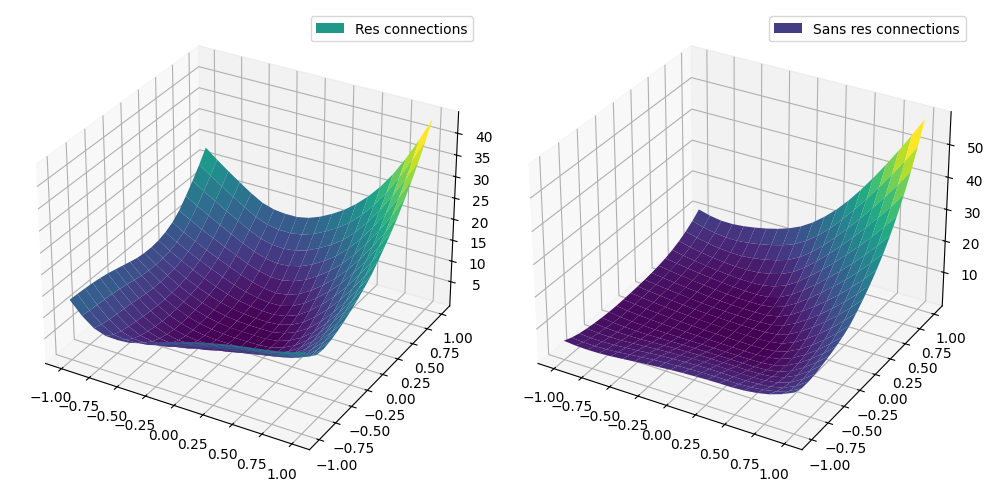

In [9]:
key = jr.PRNGKey(1)
x_sample = x_test[:10]
y_sample = y_test[:10]

# 20x20 grid in [-1, 1] x [-1, 1]
visualize = loss_landscape_2d(loss_func, key=key, min=-1, max=1, num=20)

X, Y, LOSS_RES = visualize(sk.tree_mask(res_net), x_sample, y_sample)
X, Y, LOSS_SANS = visualize(sk.tree_mask(sans_net), x_sample, y_sample)
# visualize the loss landscape
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(1, 2, 1, projection="3d")
ax2 = fig.add_subplot(1, 2, 2, projection="3d")
ax1.plot_surface(X, Y, LOSS_RES, cmap="viridis", label="Res connections")
ax2.plot_surface(X, Y, LOSS_SANS, cmap="viridis", label="Sans res connections")
ax1.legend()
ax2.legend()
plt.tight_layout()